1. 선택한 UCI 데이터셋: "Iris 데이터셋 (붓꽃 데이터)"
이유:
4개의 연속형 특징을 가진 군집화에 적합한 데이터셋.
보편적으로 K-Means 알고리즘의 성능을 평가하는 데 사용됨.
붓꽃(Iris)의 3가지 품종(Setosa, Versicolor, Virginica)을 포함.

In [9]:
# 라이브러리 및 데이터셋 로드
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.font_manager as fm
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# 📌 UCI "Iris Dataset" 로드
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# 실제 품종 정보 추가 (비지도 학습에서는 사용하지 않음)
df["species"] = iris.target

# 데이터 확인
print(df.head())
print(df.info())
print(df.describe())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species  
0        0  
1        0  
2        0  
3        0  
4        0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int32  
dtypes:

In [2]:
# 데이터 전처리
# 🎯 독립 변수(X) 선택 (4개 특성 사용)
X = df.drop(columns=["species"])  # 군집화에서는 실제 라벨을 사용하지 않음

# 📌 데이터 정규화 (표준화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


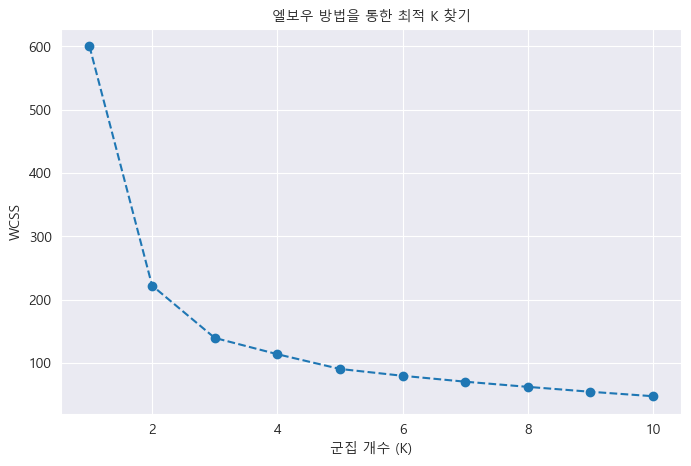

In [10]:
# 최적의 군집 수(K) 찾기 (엘보우 방법)
# K-Means는 군집 개수(K)를 사전에 설정해야 하므로,
# 최적의 K값을 찾기 위해 엘보우(Elbow) 방법을 사용합니다.

# 🎯 다양한 K값에 대한 WCSS(Within-Cluster Sum of Squares) 계산
wcss = []
for k in range(1, 11):  # 1~10개 클러스터 테스트
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # 군집 내 변동 값(WCSS) 저장

# WCSS(Within-Cluster Sum of Squares)란?
# WCSS는 각 데이터 포인트가 속한 군집 중심(centroid)과의 거리의 제곱합을 의미합니다.
# 값이 작을수록 데이터가 중심에 가깝게 밀집되어 있다는 뜻.
# K가 증가할수록 WCSS는 감소하지만, 어느 시점부터 감소율이 완만해짐 → 최적의 K를 찾는 것이 중요.

# 폰트 경로 설정
# font_path = "C:/Windows/Fonts/NanumGothic.ttf"
font_path= "C:/Windows/Fonts/malgun.ttf"  # '맑은 고딕' 폰트 경로
font_prop = fm.FontProperties(fname=font_path)

# Matplotlib 기본 폰트 설정
plt.rc('font', family=font_prop.get_name())

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


# 📊 엘보우 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker="o", linestyle="--")
plt.xlabel("군집 개수 (K)", fontproperties= font_prop)
plt.ylabel("WCSS")
plt.title("엘보우 방법을 통한 최적 K 찾기", fontproperties= font_prop)
plt.show()

# 그래프 분석
# 엘보우(elbow) 지점이 꺾이는 곳(일반적으로 K=3)을 최적의 군집 개수로 선택.

In [11]:
# K-평균 군집화(K=3) 적용
# 🎯 최적의 K값을 적용한 K-Means 모델 학습
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)  # 예측된 군집 할당

# 📌 군집별 개수 확인
print(df["cluster"].value_counts())



cluster
2    53
1    50
0    47
Name: count, dtype: int64


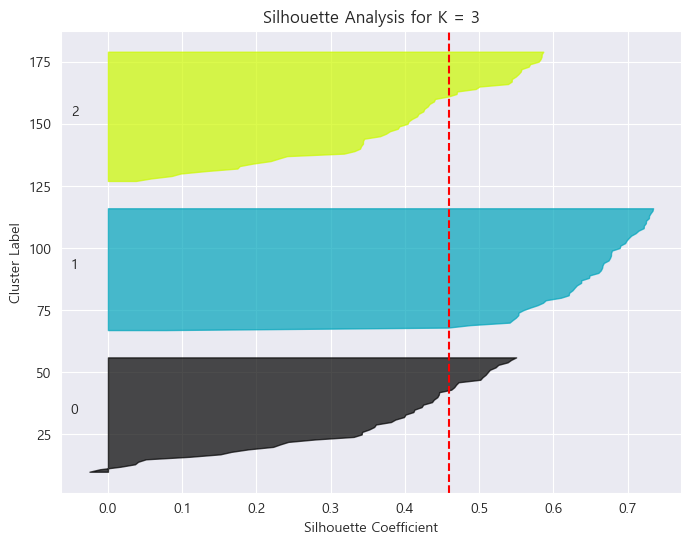

In [5]:
def silhouetteViz(n_clusters, X_features_scaled):
    cluster_labels = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit_predict(X_features_scaled)
    silhouette_avg = silhouette_score(X_features_scaled, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_features_scaled, cluster_labels)

    fig, ax1 = plt.subplots(figsize=(8, 6))

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title(f"Silhouette Analysis for K = {n_clusters}")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster Label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

# 📊 실루엣 계수 시각화 (K=3)
silhouetteViz(3, X_scaled)


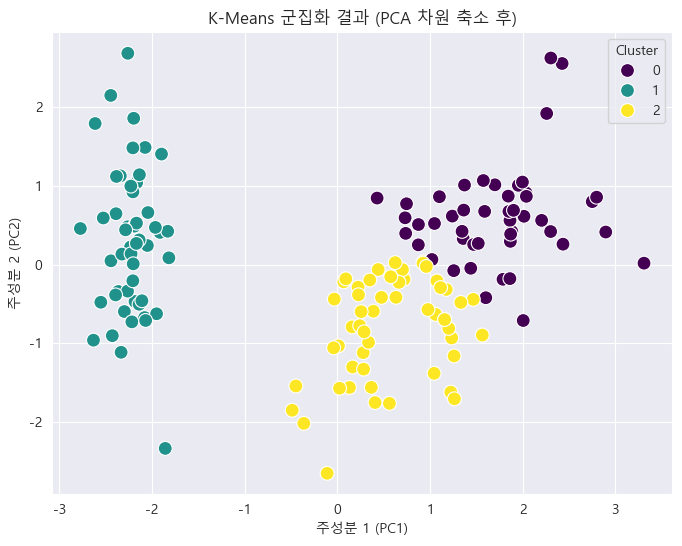

In [6]:
# PCA(주성분 분석) 적용 후 시각화
# K-Means는 4차원 공간에서 군집을 찾았기 때문에,
# PCA를 사용하여 2D로 차원 축소 후 시각화합니다.

# 📌 주성분 분석(PCA)로 2차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 📌 PCA 결과를 데이터프레임으로 변환
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["cluster"] = df["cluster"]


# 폰트 경로 설정
# font_path = "C:/Windows/Fonts/NanumGothic.ttf"
font_path= "C:/Windows/Fonts/malgun.ttf"  # '맑은 고딕' 폰트 경로
font_prop = fm.FontProperties(fname=font_path)

# Matplotlib 기본 폰트 설정
plt.rc('font', family=font_prop.get_name())

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 📊 군집 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue=df_pca["cluster"], palette="viridis", s=100)
plt.title("K-Means 군집화 결과 (PCA 차원 축소 후)")
plt.xlabel("주성분 1 (PC1)")
plt.ylabel("주성분 2 (PC2)")
plt.legend(title="Cluster")
plt.show()


In [7]:
# 클러스터링 결과 분석
# 📌 각 군집의 평균값 확인 (군집 별 특징)
cluster_means = df.groupby("cluster").mean()
print(cluster_means)


         sepal length (cm)  sepal width (cm)  petal length (cm)  \
cluster                                                           
0                 6.780851          3.095745           5.510638   
1                 5.006000          3.428000           1.462000   
2                 5.801887          2.673585           4.369811   

         petal width (cm)   species  
cluster                              
0                1.972340  1.765957  
1                0.246000  0.000000  
2                1.413208  1.264151  


In [12]:
# 🌱 샘플 데이터 3개 생성 (기존 데이터의 평균 및 표준편차 참고)
sample_data = pd.DataFrame(
    [
        [5.1, 3.5, 1.4, 0.2],  # 예제 1: Setosa에 가까운 데이터
        [6.5, 3.0, 5.2, 2.0],  # 예제 2: Versicolor 또는 Virginica에 가까운 데이터
        [7.2, 3.6, 6.1, 2.5]   # 예제 3: Virginica에 가까운 데이터
    ],
    columns=iris.feature_names
)

# 📌 스케일링 적용 (훈련 데이터와 같은 방식으로 변환)
sample_data_scaled = scaler.transform(sample_data)

# 🎯 예측 수행
sample_predictions = kmeans.predict(sample_data_scaled)

# 🔍 결과 출력
for i, pred in enumerate(sample_predictions):
    print(f"샘플 {i+1}: 예측된 군집 = Cluster {pred}")


샘플 1: 예측된 군집 = Cluster 1
샘플 2: 예측된 군집 = Cluster 0
샘플 3: 예측된 군집 = Cluster 0
